In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 7)
plt.style.use('fast')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score 

import machine_learning_tool
from machine_learning_tool import MLPipelineSD
from importlib import reload
reload(machine_learning_tool)

np.random.seed(123) # for reproducibility

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


In [2]:
import pandas
print(pandas.__version__)

1.1.0


In [3]:
import xgboost
print(xgboost.__version__)

0.90


In [4]:
import sklearn
print(sklearn.__version__)

0.23.2


In [5]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [6]:
df = pd.read_csv('df_semanal_departamental.csv')

In [7]:
df = pd.read_csv('df_semanal_departamental.csv')
dept_list=df["departamento"].drop_duplicates().values

In [8]:
df_dept=df.groupby(["departamento"])

In [9]:
df_dept_dicc={}

In [10]:
for depto in dept_list:
    df_dept_dicc[depto]=df_dept.get_group(depto)

reframed_final_PRUEBA= [4624.212    4657.8867   4653.9546   4696.659    4733.3613   4729.337
   72.68977    59.821404  117.68141   109.37186    59.41481    88.56626
   20.406242   20.699387   20.229624   19.611315   20.207699   20.24338
   22.         19.         14.         40.         34.         43.      ]
[ 0.16754031  0.17682576  0.1326623   0.05058122  0.08064485  0.02186656
 -0.762678   -0.44438976 -0.66515744 -0.29799712 -0.88017005 -0.94879204
 -0.24400568 -0.25622463 -0.23554778 -0.20210767 -0.17657161 -0.20068264
 -0.98367345 -1.         -1.         -1.         -0.98367345 -1.
 -1.        ]
(9408, 1, 24) (9408,) (5040, 1, 24) (5040,)


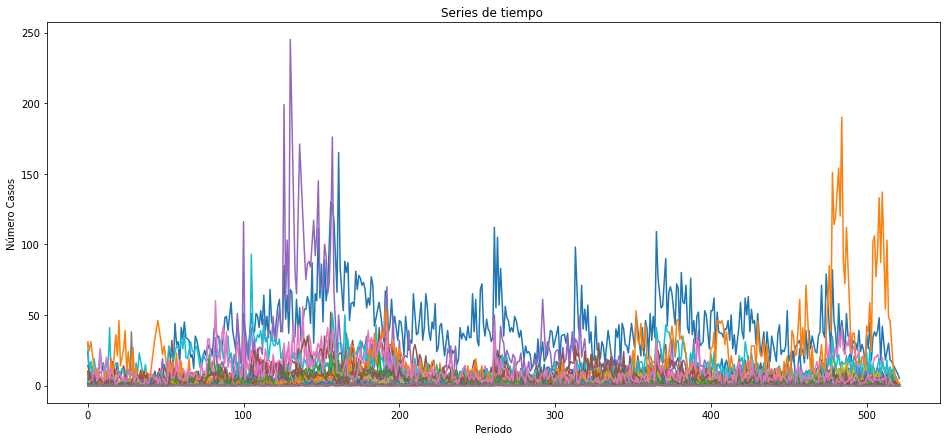

In [11]:
dept_list=df["departamento"].drop_duplicates().values

reframed_final=pd.DataFrame()
reframed_final_test=pd.DataFrame()

test_dept_dicc={}
for dept in dept_list:
    df_final=pd.DataFrame(df.query('departamento == @dept'))
    dff=pd.DataFrame()
    dff_full=pd.DataFrame()
    dff["periodo"]=df_final["periodo"]
    dff["casos_"]=df_final["casos_"]
    dff["Temperatura"]=df_final["Temperatura"]
    dff["Precipitación"]=df_final["Precipitación"]
    dff["EVI"]=df_final["EVI"]
    dff_full=dff
    
    plt.title('Series de tiempo ')
    plt.xlabel("Periodo")
    plt.ylabel("Número Casos")
    plt.plot(dff["casos_"].values)
    
    
    PASOS=6
    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    # load dataset
    values = dff["casos_"].values
    # ensure all data is float
    values = values.astype('float32')

    # frame as supervised learning
    values=values.reshape(-1, 1)
    reframed = series_to_supervised(values, PASOS, 1)
    
    # load dataset temperatura
    values1 = dff["Temperatura"].values
    # ensure all data is float
    values1 = values1.astype('float32')
    # normalize features
    values1=values1.reshape(-1, 1)
    # frame as supervised learning
    reframed1 = series_to_supervised(values1, PASOS, 1)
    reframed1=reframed1.drop("var1(t)", axis=1)
    reframed1.rename(columns = {"var1(t-12)": "tem1(t-12)", "var1(t-11)": "tem1(t-11)", "var1(t-10)": "tem1(t-10)", "var1(t-9)": "tem1(t-9)",
                               "var1(t-8)": "tem1(t-8)", "var1(t-7)": "tem1(t-7)", "var1(t-6)": "tem1(t-6)", "var1(t-5)": "tem1(t-5)",
                                "var1(t-4)":"tem1(t-4)", "var1(t-3)": "tem1(t-3)", "var1(t-2)": "tem1(t-2)", "var1(t-1)": "tem1(t-1)"}, inplace = True) 

    
    # load dataset precipitacion
    values2 = dff["Precipitación"].values
    # ensure all data is float
    values2 = values2.astype('float32')
    # normalize features
    values2=values2.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    # frame as supervised learning
    reframed2 = series_to_supervised(values2, PASOS, 1)
    reframed2=reframed2.drop("var1(t)", axis=1)
    reframed2.rename(columns = {"var1(t-12)": "pre1(t-12)", "var1(t-11)": "pre1(t-11)", "var1(t-10)": "pre1(t-10)", "var1(t-9)": "pre1(t-9)",
                               "var1(t-8)": "pre1(t-8)", "var1(t-7)": "pre1(t-7)", "var1(t-6)": "pre1(t-6)", "var1(t-5)": "pre1(t-5)",
                                "var1(t-4)":"pre1(t-4)","var1(t-3)": "pre1(t-3)", "var1(t-2)": "pre1(t-2)", "var1(t-1)": "pre1(t-1)"}, inplace = True) 
    
    
    # load dataset EVI
    values3 = dff["EVI"].values
    # ensure all data is float
    values3 = values3.astype('float32')
    # normalize features
    values3=values3.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    # frame as supervised learning
    reframed3 = series_to_supervised(values3, PASOS, 1)
    reframed3=reframed3.drop("var1(t)", axis=1)
    reframed3.rename(columns = {"var1(t-12)": "evi1(t-12)", "var1(t-11)": "evi1(t-11)", "var1(t-10)": "evi1(t-10)", "var1(t-9)": "evi1(t-9)",
                               "var1(t-8)": "evi1(t-8)", "var1(t-7)": "evi1(t-7)", "var1(t-6)": "evi1(t-6)", "var1(t-5)": "evi1(t-5)",
                                "var1(t-4)":"evi1(t-4)","var1(t-3)": "evi1(t-3)", "var1(t-2)": "evi1(t-2)", "var1(t-1)": "evi1(t-1)"}, inplace = True) 

    
    result = pd.concat([reframed3.reset_index(drop=True), reframed2.reset_index(drop=True), 
                    reframed1.reset_index(drop=True), reframed.reset_index(drop=True)], axis=1)

    reframed=result
    

    # split into train and test sets
    values = reframed
    n_train_days = 522 - (180+PASOS)
    train = values.iloc[:n_train_days, :]
    test = values.iloc[n_train_days:, :]
    
    reframed_final = pd.concat([reframed_final, train])     
    reframed_final.index = range(reframed_final.shape[0])
    test_dept_dicc[dept]=test
    reframed_final_test = pd.concat([reframed_final_test, test])
    reframed_final_test.index = range(reframed_final_test.shape[0])
    
    
print("reframed_final_PRUEBA=",reframed_final_test.iloc[0,:-1].values)
    
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
#values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(reframed_final.values)

scaled_test=scaler.transform(reframed_final_test.values)   
    
#Guardado de prueba escalada

probar=reframed_final.iloc[0,:].values
print(scaled[0])
    
for dept in dept_list:
    test_dept_dicc[dept]=pd.DataFrame(scaler.transform(test_dept_dicc[dept].values))
    
# split into input and outputs
x_train, y_train = scaled[:, :-1], scaled[:, -1]
x_val, y_val = scaled_test[:, :-1], scaled_test[:, -1]

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

In [12]:
nsamples, nx, ny = x_train.shape
d2_train_dataset = x_train.reshape((nsamples,nx*ny))
nsamples_x_val, nx_val, ny_val = x_val.shape
x_val_new = x_val.reshape((nsamples_x_val,nx_val*ny_val))

print(d2_train_dataset.shape)
print(y_train.shape)
print(x_val_new.shape)

eval_set = [(d2_train_dataset, y_train),(x_val_new, y_val)]


(9408, 24)
(9408,)
(5040, 24)


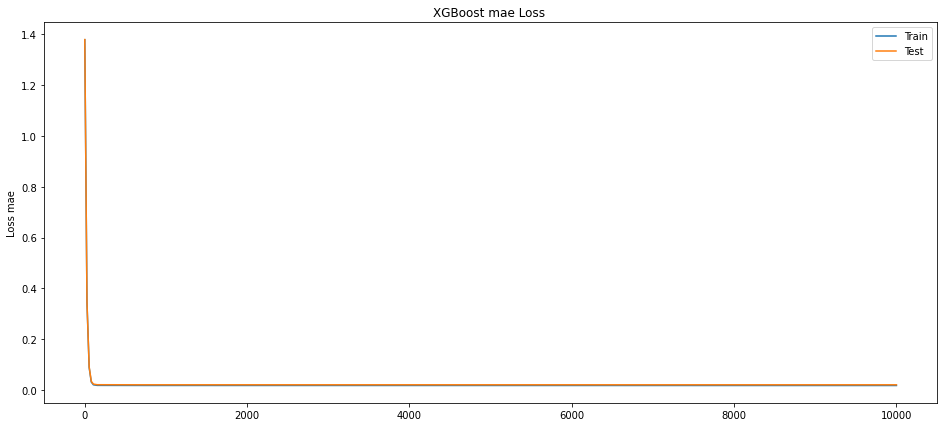

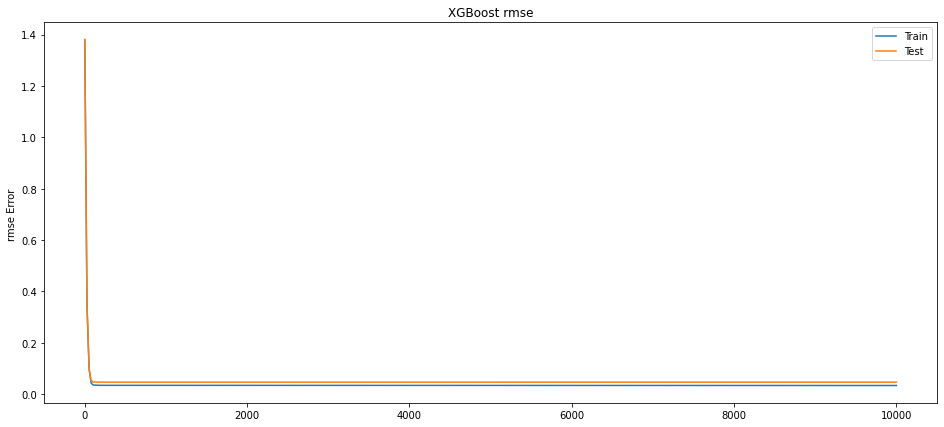

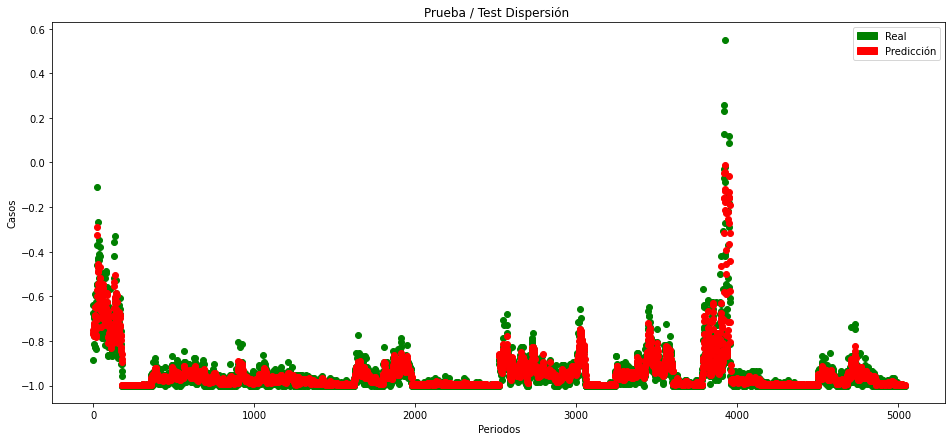

(5040, 2)
despues=  (5040, 25)
despues=  [[-0.8857143  -0.74981    -0.8857143  ... -0.8857143  -0.74981
  -0.8857143 ]
 [-0.64081633 -0.767954   -0.64081633 ... -0.64081633 -0.767954
  -0.64081633]
 [-0.6734694  -0.7639098  -0.6734694  ... -0.6734694  -0.7639098
  -0.6734694 ]
 ...
 [-1.         -0.99595094 -1.         ... -1.         -0.99595094
  -1.        ]
 [-1.         -0.99595094 -1.         ... -1.         -0.99595094
  -1.        ]
 [-1.         -0.99595094 -1.         ... -1.         -0.99595094
  -1.        ]]


,real,prediccion,diferencia
1040,3.000003,5.772548,-2.772545
1041,3.000003,4.564328,-1.564325
1042,3.999997,4.129563,-0.129566
1043,3.000003,4.172555,-1.172552
1044,1.000001,3.724355,-2.724354
...,...,...,...
5035,0.000000,0.496010,-0.496010
5036,0.000000,0.496010,-0.496010
5037,0.000000,0.496010,-0.496010
5038,0.000000,0.496010,-0.496010


compara2_PRUEBA= 30.64828


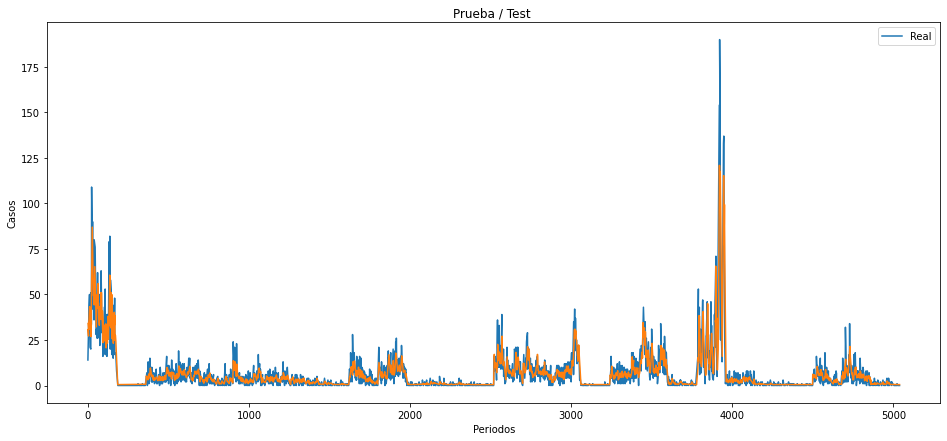

mean_absolute_error =  2.6655462
mean_squared_error =  32.10116
r2_score =  0.77546859778749
explained_variance_score =  0.7755148410797119


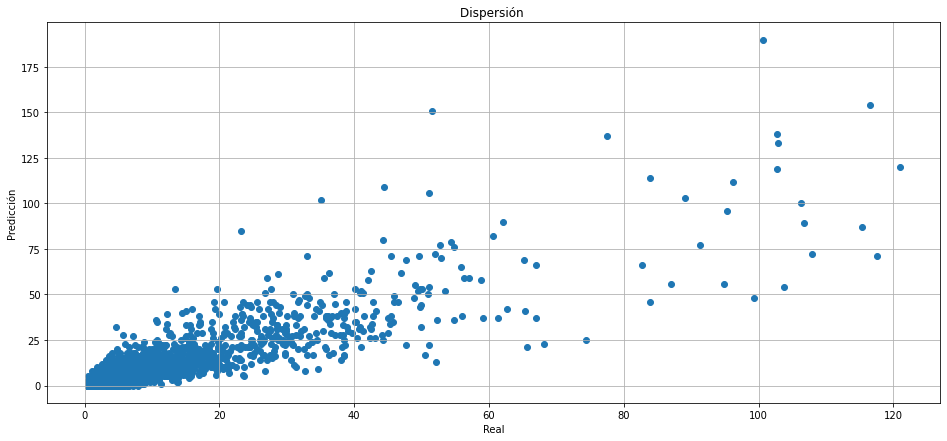

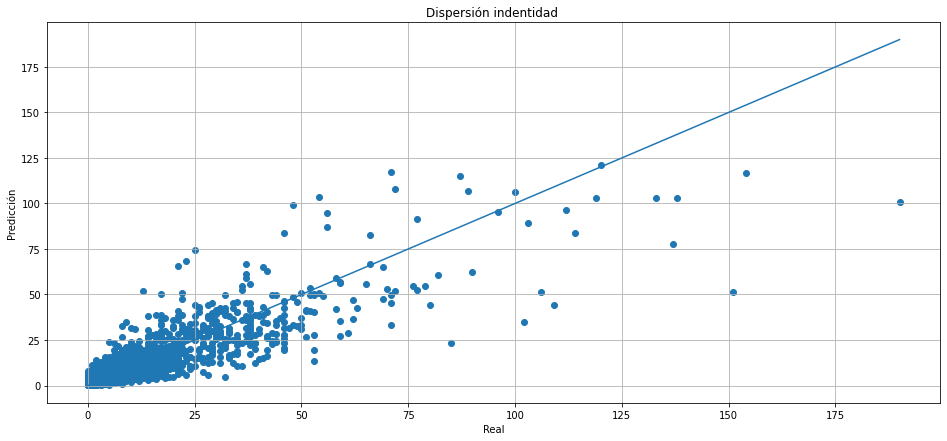

In [15]:

from xgboost import XGBRegressor
xg_reg = XGBRegressor(base_score=0.5,
 booster= 'gbtree',
 colsample_bylevel= 1,
 colsample_bynode= 1,
 colsample_bytree= 0.9,
 gamma= 0.09,
 importance_type= 'gain',
 learning_rate= 0.05,
 max_delta_step= 0,
  max_depth= 9,
 min_child_weight= 1,
 n_estimators= 10000,
 n_jobs= 11,
 objective= 'reg:squarederror',
 random_state= 7,
 reg_alpha= 0.07,
 reg_lambda= 1,
 scale_pos_weight= 1,
 subsample= 0.999,
 verbosity= 1)
xg_reg.fit(d2_train_dataset, y_train, eval_metric=["mae", "rmse"], eval_set=eval_set, verbose=False)

results2=xg_reg.predict(x_val_new)


from matplotlib import pyplot

results = xg_reg.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('Loss mae')
pyplot.title('XGBoost mae Loss ')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse Error ')
pyplot.title('XGBoost rmse')
pyplot.show()

# plt.figure()
# orange_patch = mpatches.Patch(color='orange', label='Validación')
# blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
# plt.legend(handles=[orange_patch, blue_patch])
# plt.title('Función de perdida ')
# plt.xlabel("Epoch")
# plt.ylabel("Perdida")
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.show()

# plt.figure()
# orange_patch = mpatches.Patch(color='orange', label='Validación')
# blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
# plt.legend(handles=[orange_patch, blue_patch])
# plt.title('mean_squared_error ')
# plt.xlabel("Epoch")
# plt.ylabel("Perdida")
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.show()

#4 LINEAS SIGUIENTES PARA HACER METRICAS POR DEPARTAMENTO
# for dept in dept_list:
#     dept_df=test_dept_dicc[dept]
    
#     x_val, y_val = dept_df.values[:, :-1], dept_df.values[:, -1]
#     x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

#Metricas de todo



plt.figure()
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba / Test Dispersión ')
plt.xlabel("Periodos")
plt.ylabel("Casos")
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results2)),results2,c='r')
plt.show()

compara = pd.DataFrame(np.array([y_val, [x for x in results2]])).transpose()
compara.columns = ['real', 'prediccion']
print(compara.shape)
compara=pd.concat([compara for c in range(12)]+[compara["real"]], axis=1)
print("despues= ", compara.shape)
print("despues= ", compara.values)
inverted = scaler.inverse_transform(compara.values)
compara2 = pd.DataFrame(inverted[:,-3:-1])
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
display(compara2.tail(4000))

compara2.describe()

print("compara2_PRUEBA=", compara2["prediccion"].iloc[0])

plt.figure()
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba / Test ')
plt.xlabel("Periodos")
plt.ylabel("Casos")
compara2['real'].plot()
compara2['prediccion'].plot()
plt.show()

print("mean_absolute_error = ",mean_absolute_error(compara2["real"], compara2["prediccion"]))
print("mean_squared_error = ",mean_squared_error(compara2["real"], compara2["prediccion"]))
print("r2_score = ", r2_score(compara2["real"], compara2["prediccion"]))
print("explained_variance_score = ",explained_variance_score(compara2["real"], compara2["prediccion"]))

plt.figure()
plt.title('Dispersión ')
plt.xlabel("Real")
plt.ylabel("Predicción")
x = compara2["real"].values
y = compara2["prediccion"].values
plt.scatter(y, x)
plt.grid(True)
plt.show()

plt.figure()
identity_line = np.linspace(x.min(), x.max())
plt.scatter(x, y)
plt.title('Dispersión indentidad ')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.plot(identity_line, identity_line)
plt.grid(True)
plt.show()




## Guardar modelo y scaler

In [30]:
import pickle

In [31]:
pickle.dump(xg_reg, open("model_XGB_1_temporales.pickle", "wb"))

In [32]:
pickle.dump(scaler, open("scaler_XGB_1_temporales.pickle", "wb"))

In [9]:
model_load=pickle.load(open("model.pickle", "rb"))

[20:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
scaler_load=pickle.load(open("scaler.pickle", "rb"))

In [29]:
a=np.array([[0.00000003,24,3,4111111, 0.009,240,30,411111187878787,2444,344,411111441, 0.743, 0.74311, 45, 2489,3,4111118989891, 0.93,24,3,4111111,1,2,3,4]])
len(a[0])

25

In [15]:
probar=probar.reshape(1,25)
probar

array([[4.3223003e+03, 4.3391421e+03, 4.2590386e+03, 4.1101602e+03,
        4.1646895e+03, 4.0580779e+03, 3.0701490e+01, 7.1852501e+01,
        4.3309784e+01, 9.0779381e+01, 1.5511126e+01, 6.6390958e+00,
        2.0522871e+01, 2.0408476e+01, 2.0602057e+01, 2.0915127e+01,
        2.1154200e+01, 2.0928469e+01, 2.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [17]:
probar_test=probar[0][24]
probar_test

0.0

In [18]:
#scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler_load.transform(probar)
scaled

array([[ 0.16754031,  0.17682576,  0.1326623 ,  0.05058122,  0.08064485,
         0.02186656, -0.762678  , -0.44438976, -0.66515744, -0.29799712,
        -0.88017005, -0.94879204, -0.24400568, -0.25622463, -0.23554778,
        -0.20210767, -0.17657161, -0.20068264, -0.98367345, -1.        ,
        -1.        , -1.        , -0.98367345, -1.        , -1.        ]],
      dtype=float32)

In [19]:
np.array([[1,2,3,4]]).shape

(1, 4)

In [ ]:
scaled_new=np.delete(scaled[0], len(scaled[0])-1, 0)
scaled_new=scaled_new.reshape(1,24)

In [29]:
xg_pk=model_load.predict(scaled_new)
scaled_new

array([[ 0.16754031,  0.17682576,  0.1326623 ,  0.05058122,  0.08064485,
         0.02186656, -0.762678  , -0.44438976, -0.66515744, -0.29799712,
        -0.88017005, -0.94879204, -0.24400568, -0.25622463, -0.23554778,
        -0.20210767, -0.17657161, -0.20068264, -0.98367345, -1.        ,
        -1.        , -1.        , -0.98367345, -1.        ]],
      dtype=float32)

In [36]:
scaled_new_result=np.append(scaled_new, xg_pk[0])
scaled_new_result=scaled_new_result.reshape(1,25)

In [42]:
compara = pd.DataFrame()
compara['real']=probar_test
compara['prediccion']=xg_pk[0]
print(compara.shape)

inverted = scaler_load.inverse_transform(scaled_new_result)
print("inverted = ",inverted)
compara2 = pd.DataFrame(inverted[:,-3:-1])
display("compara2 = ", compara2)
compara2.columns = ['prediccion', 'real']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
display(compara2.tail(4000))

(0, 2)
inverted =  [[4.3223003e+03 4.3391421e+03 4.2590386e+03 4.1101602e+03 4.1646895e+03
  4.0580779e+03 3.0701492e+01 7.1852501e+01 4.3309780e+01 9.0779381e+01
  1.5511127e+01 6.6390944e+00 2.0522871e+01 2.0408476e+01 2.0602055e+01
  2.0915127e+01 2.1154198e+01 2.0928467e+01 2.0000021e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.0000021e+00 0.0000000e+00 1.3280678e+00]]


'compara2 = '

,0,1
0,2.000002,0.0


,prediccion,real,diferencia
0,2.000002,0.0,-2.000002


In [44]:
print("mean_absolute_error = ",mean_absolute_error(compara2["real"], compara2["prediccion"]))
print("mean_squared_error = ",mean_squared_error(compara2["real"], compara2["prediccion"]))
print("r2_score = ", r2_score(compara2["real"], compara2["prediccion"]))
print("explained_variance_score = ",explained_variance_score(compara2["real"], compara2["prediccion"]))

mean_absolute_error =  2.0000021
mean_squared_error =  4.0000086
r2_score =  nan
explained_variance_score =  1.0


C:\Users\danny\.conda\envs\env_asus_old\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## Metricas

### Distribución de la variable casos

In [17]:
dff["casos_"].value_counts()

0    318
1    141
2     35
3     21
4      5
6      1
5      1
Name: casos_, dtype: int64

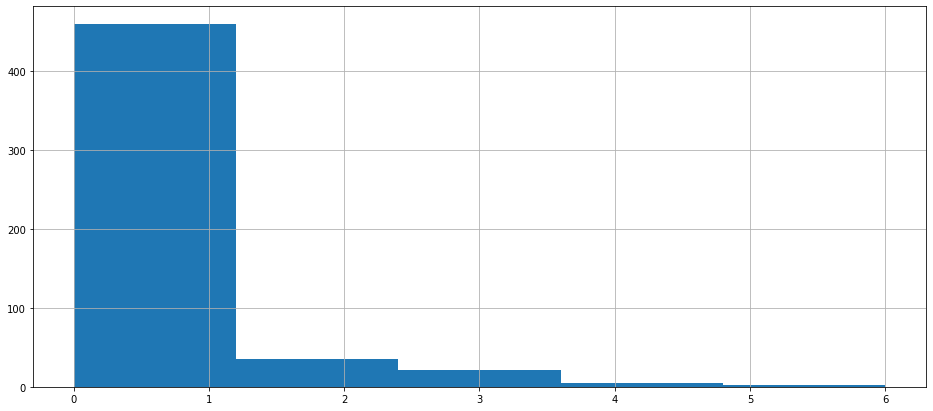

In [40]:
hist2 = dff["casos_"].hist(bins=5)

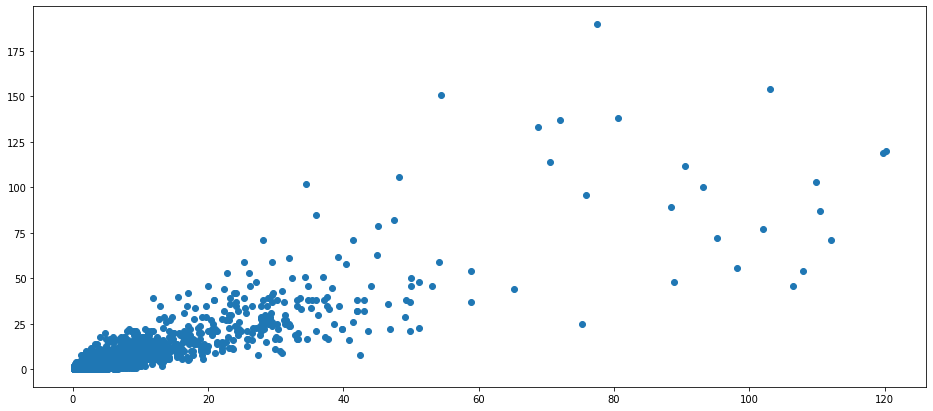

In [41]:
import matplotlib.pyplot as plt

x = compara2["real"].values
y = compara2["prediccion"].values

plt.scatter(y, x)
plt.show()

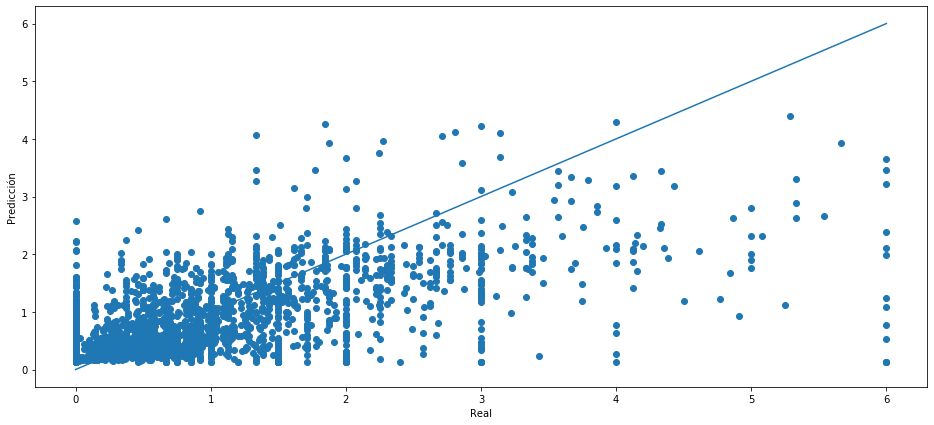

In [64]:
identity_line = np.linspace(x.min(), x.max())
plt.scatter(x, y)
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.plot(identity_line, identity_line)

In [ ]:
xg_reg